https://www.tensorflow.org/tutorials/layers

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Imports
import numpy as np
import tensorflow as tf
import cv2
import sys
import matplotlib
from matplotlib import pyplot as plt
import pylab as pl
import math

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

tf.logging.set_verbosity(tf.logging.INFO)




/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


preprocess the image by adding filters

In [2]:
def cnn_model_fn(X, labels, is_training):

  # Input Layer
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  # MNIST images are 28x28 pixels, and have one color channel
    input_layer = tf.reshape(X, [-1, 227, 227, 1])

  # Convolutional Layer #1
  # Computes 32 features using a 5x5 filter with ReLU activation.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 227, 227, 1]
  # Output Tensor Shape: [batch_size, 227, 227, 32]
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)
    bn1act = tf.layers.batch_normalization(inputs=conv1, training=is_training)

  # Pooling Layer #1
  # First max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 227, 227, 32]
  # Output Tensor Shape: [batch_size, 113, 113, 32]
    pool1 = tf.layers.max_pooling2d(inputs=bn1act, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2
  # Computes 64 features using a 5x5 filter.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 113, 113, 32]
  # Output Tensor Shape: [batch_size, 113, 113, 64]
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    bn2act = tf.layers.batch_normalization(inputs=conv2, training=is_training)

  # Pooling Layer #2
  # Second max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 113, 113, 64]
  # Output Tensor Shape: [batch_size, 56, 56, 64]
    pool2 = tf.layers.max_pooling2d(inputs=bn2act, pool_size=[2, 2], strides=2)

  # Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 56, 56, 64]
  # Output Tensor Shape: [batch_size, 56 * 56 * 64]
    pool2_flat = tf.reshape(pool2, [-1, 56 * 56 * 64])

  # Dense Layer
  # Densely connected layer with 1024 neurons
  # Input Tensor Shape: [batch_size, 56 * 56 * 64]
  # Output Tensor Shape: [batch_size, 1024]
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    bn3act = tf.layers.batch_normalization(inputs=dense, training=is_training)

  # Add dropout operation; 0.6 probability that element will be kept
    dropout = tf.layers.dropout(
      inputs=bn3act, rate=0.4, training=is_training)

  # Logits layer
  # Input Tensor Shape: [batch_size, 1024]
  # Output Tensor Shape: [batch_size, 2]
    logits = tf.layers.dense(inputs=dropout, units=2,activation=None)
    return logits
    



#   predictions = {
#       # Generate predictions (for PREDICT and EVAL mode)
#       "classes": tf.argmax(input=logits, axis=1),
#       # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
#       # `logging_hook`.
#       "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
#   }
#   if mode == tf.estimator.ModeKeys.PREDICT:
#     return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
#   loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits)

#   # Configure the Training Op (for TRAIN mode)
#   if mode == tf.estimator.ModeKeys.TRAIN:
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
#     train_op = optimizer.minimize(
#         loss=loss,
#         global_step=tf.train.get_global_step())
#     return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

#   # Add evaluation metrics (for EVAL mode)
#   eval_metric_ops = {
#       "accuracy": tf.metrics.accuracy(
#           labels=labels, predictions=predictions["classes"])}
#   return tf.estimator.EstimatorSpec(
#       mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)



In [3]:
#   mnist = tf.contrib.learn.datasets.load_dataset("mnist")
#   train_data = mnist.train.images  # Returns np.array
#   train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
#   eval_data = mnist.test.images  # Returns np.array
#   eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

#   # Create the Estimator
#   mnist_classifier = tf.estimator.Estimator(
#       model_fn=cnn_model_fn, model_dir="/tmp/mnist_convnet_model")

#   # Set up logging for predictions
#   # Log the values in the "Softmax" tensor with label "probabilities"
#   tensors_to_log = {"probabilities": "softmax_tensor"}
#   logging_hook = tf.train.LoggingTensorHook(
#       tensors=tensors_to_log, every_n_iter=50)

#   # Train the model
#   train_input_fn = tf.estimator.inputs.numpy_input_fn(
#       x={"x": train_data},
#       y=train_labels,
#       batch_size=100,
#       num_epochs=None,
#       shuffle=True)
#   mnist_classifier.train(
#       input_fn=train_input_fn,
#       steps=20000,
#       hooks=[logging_hook])

#   # Evaluate the model and print results
#   eval_input_fn = tf.estimator.inputs.numpy_input_fn(
#       x={"x": eval_data},
#       y=eval_labels,
#       num_epochs=1,
#       shuffle=False)
#   eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
#   print(eval_results)

In [4]:
def normalize_grayscale(image, beta=0.75, image_id_k = 1, A_kp=None):
    N,M = image.shape
    k = image_id_k
    
    if image_id_k > 1 and  A_kp is None :
        print("please define A_kp as this is not the first image")
    elif image_id_k == 1:
        A_kp = np.zeros((N,M))
        
    alpha = beta*(k-1)/k
    a = np.mean(image, axis=0)
    A_k = alpha*A_kp + (1-alpha)*np.tile(a,(N,1))
    image = 128*(image/A_k)
    return image, A_k


In [6]:
#read the data
#train 500 negatives and 500 positives
#use 50 negatives and 50 positives to validate
#100 negatives and 100 positives to test
X_train=[]
Y_train=[]
X_test=[]
Y_test=[] 
X_val=[]
Y_val=[]  

for i in range(1,501):
    j  = i + 1600
    txt = '../Positive/0'+str(j).zfill(4)+'.jpg'
    img = cv2.imread(txt, 0).astype(np.float32)
    X_train.append(img)
    Y_train.append(1)

for i in range(1,501):
    j  = i + 1600
    txt = '../Negative/0'+str(j).zfill(4)+'.jpg'
    img = cv2.imread(txt, 0).astype(np.float32)
    X_train.append(img)
    Y_train.append(0)
    
for i in range(1,51):
    j  = i + 1000
    txt = '../Positive/1'+str(i).zfill(4)+'_1.jpg'
    img = cv2.imread(txt, 0).astype(np.float32)
    X_val.append(img)
    Y_val.append(1)

for i in range(1,51):
    j  = i + 1000
    txt = '../Negative/1'+str(i).zfill(4)+'.jpg'
    img = cv2.imread(txt, 0).astype(np.float32)
    X_val.append(img)
    Y_val.append(0)

   
for i in range(1,101):
    j  = i + 1000
    txt = '../Positive/1'+str(j).zfill(4)+'_1.jpg'
    img = cv2.imread(txt, 0).astype(np.float32)
    X_test.append(img)
    Y_test.append(1)

for i in range(1,101):
    j  = i + 1000
    txt = '../Negative/1'+str(j).zfill(4)+'.jpg'
    img = cv2.imread(txt, 0).astype(np.float32)
    X_test.append(img)
    Y_test.append(0)

X_test=np.asarray(X_test)
Y_test=np.asarray(Y_test)    
X_val=np.asarray(X_val)
Y_val=np.asarray(Y_val)
X_train=np.asarray(X_train)
Y_train=np.asarray(Y_train)
# features={"x_train":X_train}
# labels=Y_train
# def train_input_fn(features, labels, batch_size):
#     """An input function for training"""
#     # Convert the inputs to a Dataset.
#     dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

#     # Shuffle, repeat, and batch the examples.
#     dataset = dataset.shuffle(1000).repeat().batch(batch_size)

#     # Build the Iterator, and return the read end of the pipeline.
#     return dataset.make_one_shot_iterator().get_next()
# features_result,labels_result=train_input_fn(features, labels, 10)    


def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    train_indicies = np.arange(Xd.shape[0])
    
    training_now = (training is not None)
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss, correct_prediction, accuracy]
    if training_now:
        variables[-1] = training

    # counter 
    iter_cnt = 0
    # keep track of losses
    losses = []
    for e in range(epochs):
        # shuffle indicies
        np.random.shuffle(train_indicies)
        # keep track of accuracy
        correct = 0
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            corr = np.array(corr).astype(np.float32)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        
    if plot_losses:
        plt.plot(losses)
        plt.grid(True)
        plt.title('Epoch {} Loss'.format(e+1))
        plt.xlabel('minibatch number')
        plt.ylabel('minibatch loss')
        plt.show()
            
    return total_loss,total_correct,losses

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 227, 227])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = cnn_model_fn(X,y,is_training)
total_loss = tf.losses.softmax_cross_entropy(logits=y_out, onehot_labels=tf.one_hot(y,2))
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.AdamOptimizer(1e-4) #adam
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

# txt = '../Negative/00001.jpg'
# img = cv2.imread(txt, 0).astype(np.float32)
# print(img2.shape)
# plt.figure(figsize=(10,5))
# plt.subplot(121),plt.imshow(img, cmap='gray')
# plt.title('Original'),plt.xticks([]),plt.yticks([])
# plt.show()

In [ ]:
# sess = tf.Session()

# sess.run(tf.global_variables_initializer())
# print('Training')
# run_model(sess,y_out,mean_loss,X_train,Y_train,10,64,100,train_step,True)

In [ ]:
# print('Validation')
# run_model(sess,y_out,mean_loss,X_val,Y_val,1,64)
# print('Test')
# run_model(sess,y_out,mean_loss,X_test,Y_test,1,64)

Training with 1000 training data entries 10 epoch, validate with 50 data entries and test with 100 data entries:

Validation

Epoch 1, Overall loss = 0.247 and accuracy of 0.94

Test

Epoch 1, Overall loss = 0.298 and accuracy of 0.89


## TODO: test the accuracy on positive and negative 
## add filter and train again (with maybe 500 data entries for training)

In [10]:
def run_model_TF(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    
    # have tensorflow compute accuracy
    predictions=tf.argmax(predict,1)
    actuals=y 
    ones_like_actuals = tf.ones_like(actuals)
    zeros_like_actuals = tf.zeros_like(actuals)
    ones_like_predictions = tf.ones_like(predictions)
    zeros_like_predictions = tf.zeros_like(predictions)
    tp_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, ones_like_actuals), 
        tf.equal(predictions, ones_like_predictions)
      ), 
      "float"
    )
  )
    tn_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, zeros_like_actuals), 
        tf.equal(predictions, zeros_like_predictions)
      ), 
      "float"
    )
  )
    fp_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, zeros_like_actuals), 
        tf.equal(predictions, ones_like_predictions)
      ), 
      "float"
    )
  )
    fn_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, ones_like_actuals), 
        tf.equal(predictions, zeros_like_predictions)
      ), 
      "float"
    )
  )
    
    
    
    
    
    
    
#     correct_prediction = tf.equal(tf.argmax(predict,1), y)
#     accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    
    train_indicies = np.arange(Xd.shape[0])
    
    training_now = (training is not None)
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss, tp_op, tn_op, fp_op, fn_op]
    if training_now:
        variables[-1] = training

    # counter 
    iter_cnt = 0
    # keep track of losses
    losses = []
    tprs=[]
    tnrs=[]
    for e in range(epochs):
        # shuffle indicies
        np.random.shuffle(train_indicies)

        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, tp, tn, fp, fn = session.run(variables,feed_dict=feed_dict)

            if fn is None:
                fn=batch_size-tp-tn-fp
            
            print(tp,tn,fp,fn)
            tpr = float(tp)/(float(tp) + float(fn))
            fpr = float(fp)/(float(tp) + float(fn))
            tnr=float(tn)/(float(tn) + float(fp))
            accuracy = (float(tp) + float(tn))/(float(tp) + float(fp) + float(fn) + float(tn))
            
            recall = tpr
            precision = float(tp)/(float(tp) + float(fp))
            f1_score = (2 * (precision * recall)) / (precision + recall)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            tprs.append(tpr)
            tnrs.append(tnr)

            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g},tpr of {2:.2g} and tnr of {3:.2g}"\
                      .format(iter_cnt,loss,tpr,tnr))
            iter_cnt += 1
        total_tpr = np.sum(tprs)/Xd.shape[0]
        total_tnr=np.sum(tnrs)/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {3}, Overall loss = {0:.3g} tpr of {1:.3g} and tnr of {2:.3g}"\
              .format(total_loss,total_tpr,total_tnr,e+1))
        
    if plot_losses:
        plt.plot(losses)
        plt.grid(True)
        plt.title('Epoch {} Loss'.format(e+1))
        plt.xlabel('minibatch number')
        plt.ylabel('minibatch loss')
        plt.show()
            
    return total_loss,total_tpr,total_tnr,losses



Training
18.0 6.0 23.0 17.0
Iteration 0: with minibatch training loss = 1.55,tpr of 0.51 and tnr of 0.21
24.0 30.0 3.0 7.0
23.0 36.0 2.0 3.0
22.0 28.0 5.0 9.0
30.0 28.0 0.0 6.0
25.0 36.0 0.0 3.0
31.0 28.0 2.0 3.0
34.0 20.0 0.0 10.0
27.0 31.0 1.0 5.0
25.0 30.0 8.0 1.0
23.0 32.0 5.0 4.0
29.0 32.0 2.0 1.0
27.0 24.0 7.0 6.0
30.0 29.0 1.0 4.0
27.0 28.0 2.0 7.0
18.0 20.0 1.0 25.0
Epoch 1, Overall loss = 0.693 tpr of 0.0128 and tnr of 0.014
26.0 34.0 2.0 2.0
29.0 30.0 1.0 4.0
31.0 28.0 0.0 5.0
30.0 30.0 1.0 3.0
28.0 32.0 0.0 4.0
32.0 25.0 0.0 7.0
29.0 34.0 0.0 1.0
33.0 23.0 0.0 8.0
31.0 26.0 2.0 5.0
32.0 30.0 0.0 2.0
29.0 35.0 0.0 0.0
27.0 31.0 0.0 6.0
26.0 37.0 0.0 1.0
21.0 42.0 1.0 0.0
31.0 33.0 0.0 0.0
17.0 23.0 0.0 24.0
Epoch 2, Overall loss = 0.865 tpr of 0.0269 and tnr of 0.0298


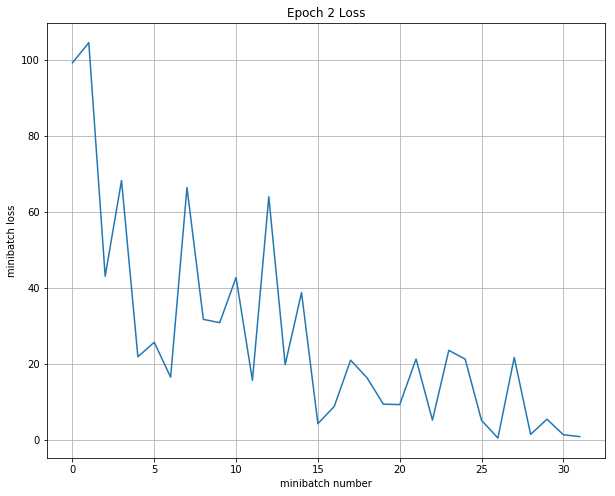

Validation
0.0 32.0 0.0 32.0


ZeroDivisionError: float division by zero

In [11]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model_TF(sess,y_out,mean_loss,X_train,Y_train,2,64,100,train_step,True)
print('Validation')
run_model_TF(sess,y_out,mean_loss,X_val,Y_val,1,64)
print('Test')
run_model_TF(sess,y_out,mean_loss,X_test,Y_test,1,64)